# Helper Function

In [22]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

def count_images(directory, classes):
    counts = []
    total_count = 0  # Variable to store the total count for all classes
    for emotion_class in classes:
        class_path = os.path.join(directory, emotion_class)
        num_images = len(os.listdir(class_path))
        counts.append(num_images)
        total_count += num_images
    counts.append(total_count)  # Append the total count at the end
    return counts

def plot_emotion_distribution(train_dir, test_dir, classes, colors, labels):
    train_counts = count_images(train_dir, classes)
    test_counts = count_images(test_dir, classes)

    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(classes) + 1)  # Increase the length by 1 for the total count bar

    for i, (count, color) in enumerate(zip([train_counts, test_counts], colors)):
        ax.bar(index + i * bar_width, count, bar_width, label=f'{["Train", "Test"][i]}')

    for i, count in enumerate(train_counts):
        ax.text(i, count + 10, str(count), ha='center', va='bottom')

    for i, count in enumerate(test_counts):
        ax.text(i + bar_width, count + 10, str(count), ha='center', va='bottom')

    ax.set_xlabel('Emotion Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Distribution of Images in Train and Test Sets')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels + ['Total'])  # Add 'Total' label to the x-axis
    ax.legend()

    plt.show()

# Import the Data

In [23]:
walk_through_dir("D:\Code\py_code\Convolutional-Neural-Network\data")

There are 2 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test'.
There are 0 directories and 213 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\angry'.
There are 0 directories and 207 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\happy'.
There are 0 directories and 149 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\sad'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train'.
There are 0 directories and 850 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\angry'.
There are 0 directories and 830 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\happy'.
There are 0 directories and 598 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\sad'.


In [24]:
train_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\train"
test_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\test"

### **Dataset Visualization**

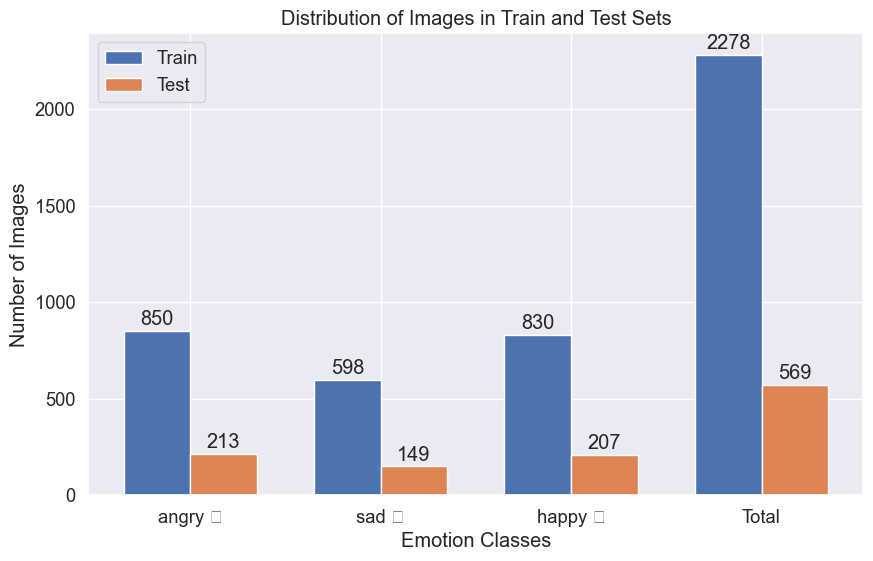

In [25]:
emotion_classes = ['angry', 'sad', 'happy']
emotion_labels = ['angry 😡', 'sad 😭', 'happy 😁']

plot_emotion_distribution(train_dir, test_dir, emotion_classes, colors=['red', 'blue'],labels=emotion_labels)

### **Hyperparameters for the Next Step**

In [26]:
IMG_HEIGHT = 71
IMG_WIDTH = 71
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 1e-1
FINE_TUNING_LR = 1e-3
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3

# Reproducibility Settings

In [27]:
import tensorflow as tf

tf.keras.utils.set_random_seed(12)
np.random.seed(12)
tf.random.set_seed(12)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(12)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Preprocessing the Data

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess_fun = tf.keras.applications.xception.preprocess_input

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.05,
    rotation_range=20,
    rescale=1./255,
    preprocessing_function=preprocess_fun,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=preprocess_fun,
                                  )

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",  
    seed=12
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",  
    seed=12
)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   seed=12
                                                  )

Found 1823 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


# Create Model

In [29]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.Xception(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### **Model Summary**

In [30]:
model = define_compile_model()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

# Training the Model

In [31]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
29/29 [==============================] - 9s 204ms/step - loss: 15.7234 - accuracy: 0.3653 - val_loss: 14.8538 - val_accuracy: 0.3736
Epoch 2/30
29/29 [==============================] - 5s 172ms/step - loss: 14.0778 - accuracy: 0.4169 - val_loss: 13.3556 - val_accuracy: 0.3648
Epoch 3/30
29/29 [==============================] - 5s 173ms/step - loss: 12.5861 - accuracy: 0.4909 - val_loss: 12.0310 - val_accuracy: 0.3648
Epoch 4/30
29/29 [==============================] - 5s 172ms/step - loss: 11.2786 - accuracy: 0.5250 - val_loss: 10.8278 - val_accuracy: 0.3648
Epoch 5/30
29/29 [==============================] - 5s 169ms/step - loss: 10.1253 - accuracy: 0.5436 - val_loss: 10.8720 - val_accuracy: 0.3736
Epoch 6/30
29/29 [==============================] - 5s 171ms/step - loss: 9.0698 - accuracy: 0.5760 - val_loss: 8.8144 - val_accuracy: 0.3648
Epoch 7/30
29/29 [==============================] - 5s 170ms/step - loss: 8.1277 - accuracy: 0.6007 - val_loss: 7.9810 - val_accuracy: 0.3

### **Fine Tuning**

In [32]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = False

model.compile(optimizer=tf.keras.optimizers.SGD(FINE_TUNING_LR), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator, callbacks= [earlyStoppingCallback])

Epoch 1/20
29/29 [==============================] - 6s 135ms/step - loss: 0.8497 - accuracy: 0.8689 - val_loss: 1.5508 - val_accuracy: 0.6637
Epoch 2/20
29/29 [==============================] - 3s 104ms/step - loss: 0.8205 - accuracy: 0.8886 - val_loss: 1.5061 - val_accuracy: 0.6637
Epoch 3/20
29/29 [==============================] - 3s 106ms/step - loss: 0.8193 - accuracy: 0.8875 - val_loss: 1.5028 - val_accuracy: 0.6945
Epoch 4/20
29/29 [==============================] - 3s 101ms/step - loss: 0.8251 - accuracy: 0.8837 - val_loss: 1.5247 - val_accuracy: 0.6747
Epoch 5/20
29/29 [==============================] - 3s 102ms/step - loss: 0.8075 - accuracy: 0.8881 - val_loss: 1.5187 - val_accuracy: 0.6725
Epoch 6/20
29/29 [==============================] - 3s 107ms/step - loss: 0.8104 - accuracy: 0.8892 - val_loss: 1.5033 - val_accuracy: 0.6703
Epoch 6: early stopping


In [33]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

In [34]:
preds_ts = model.predict(test_generator)
y_preds_ts = np.argmax(preds_ts , axis=1)
y_test = np.array(test_generator.labels)

preds_tr = model.predict(train_generator)
y_preds_tr = np.argmax(preds_tr , axis=1)
y_train = np.array(train_generator.labels)

preds_vl = model.predict(validation_generator)
y_preds_vl = np.argmax(preds_vl , axis=1)
y_validation = np.array(validation_generator.labels)

8/8 [==============================] - 1s 74ms/step


# Model Evaluation

In [35]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score

### **Train Report**

In [36]:
loss, accuracy = model.evaluate(train_generator)
print(f" Training Loss: {loss}, Training Accuracy: {accuracy}")

29/29 [==============================] - 2s 79ms/step - loss: 0.8119 - accuracy: 0.8854
 Training Loss: 0.8119117021560669, Training Accuracy: 0.8853538036346436


### **Test Report**

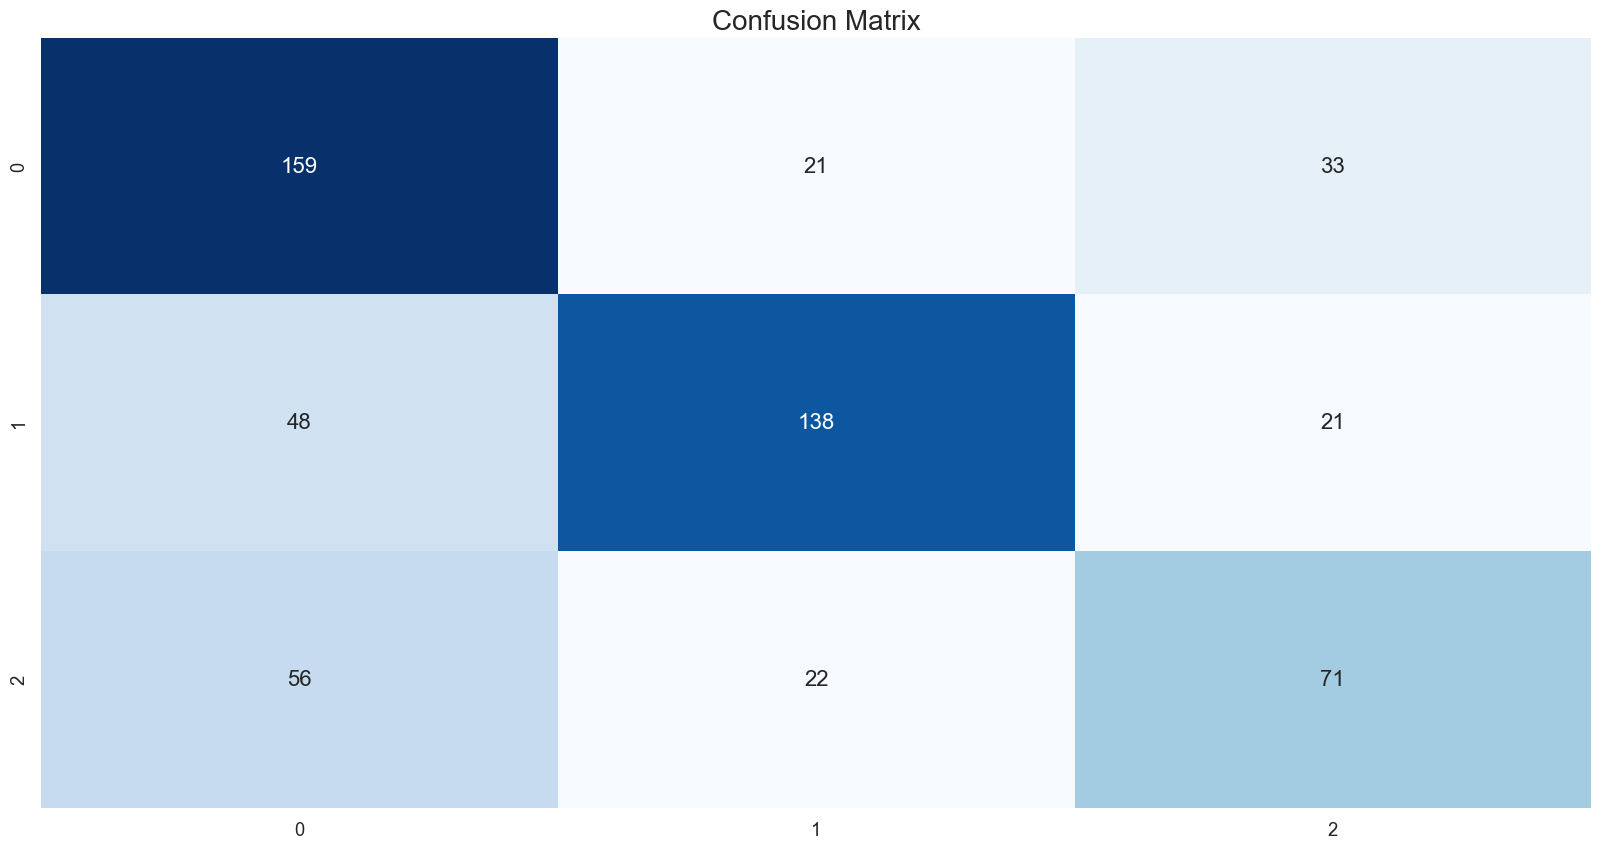

In [37]:
cm_test = confusion_matrix(y_test , y_preds_ts)
cm_ts = pd.DataFrame(cm_test, columns=emotion_classes, index = emotion_classes)
cm_ts.index.name = 'Actual'
cm_ts.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_test, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [38]:
model.evaluate(test_generator)

9/9 [==============================] - 0s 38ms/step - loss: 1.6538 - accuracy: 0.6467


[1.6538208723068237, 0.6467486619949341]

In [39]:
print(classification_report(y_test , y_preds_ts))
test_report = classification_report(y_test , y_preds_ts, output_dict=True)
print(f"Test accuracy : {test_report['accuracy']}")

              precision    recall  f1-score   support

           0       0.60      0.75      0.67       213
           1       0.76      0.67      0.71       207
           2       0.57      0.48      0.52       149

    accuracy                           0.65       569
   macro avg       0.64      0.63      0.63       569
weighted avg       0.65      0.65      0.64       569

Test accuracy : 0.6467486818980668


### **Validation Report**

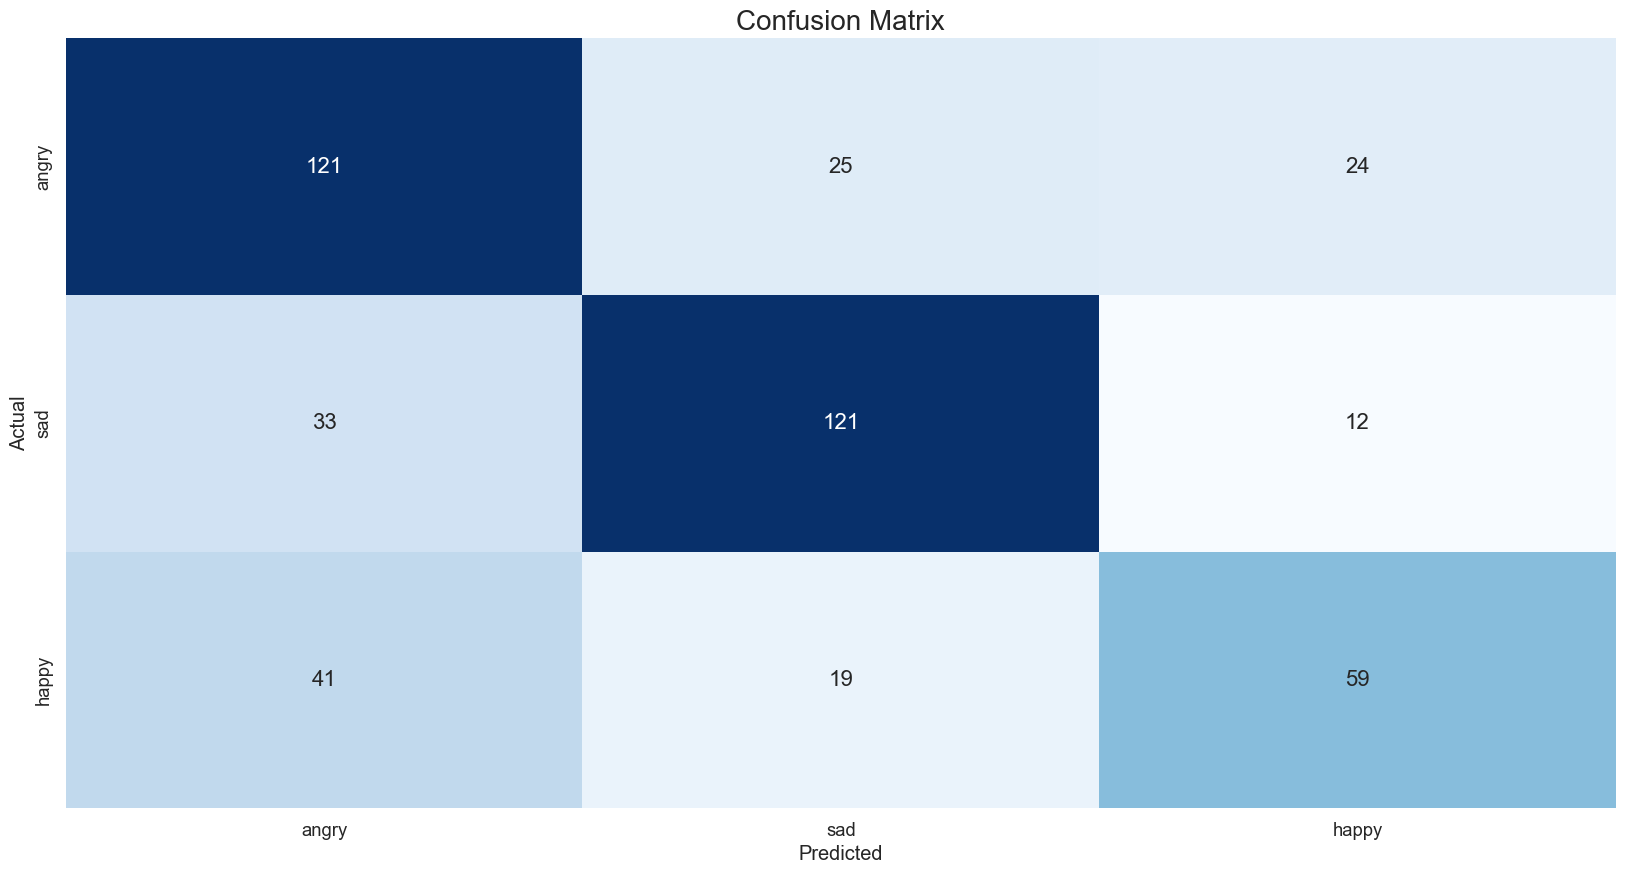

In [40]:
cm_validation = confusion_matrix(y_validation , y_preds_vl)
cm_vl = pd.DataFrame(cm_validation, columns=emotion_classes, index = emotion_classes)
cm_vl.index.name = 'Actual'
cm_vl.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_vl, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [41]:
print(classification_report(y_validation , y_preds_vl))
validation_report = classification_report(y_validation , y_preds_vl, output_dict=True)
print(f"Validation accuracy : {validation_report['accuracy']}")

              precision    recall  f1-score   support

           0       0.62      0.71      0.66       170
           1       0.73      0.73      0.73       166
           2       0.62      0.50      0.55       119

    accuracy                           0.66       455
   macro avg       0.66      0.65      0.65       455
weighted avg       0.66      0.66      0.66       455

Validation accuracy : 0.6615384615384615


# Parameter and Result 

In [42]:
parameters = {
    'IMG_HEIGHT': IMG_HEIGHT,
    'IMG_WIDTH': IMG_WIDTH,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'FINE_TUNING_EPOCHS': FINE_TUNING_EPOCHS,
    'LR': LR,
    'FINE_TUNING_LR': FINE_TUNING_LR,
    'NUM_CLASSES': NUM_CLASSES,
    'EARLY_STOPPING_CRITERIA': EARLY_STOPPING_CRITERIA
}

result = {
    "TRAINING LOSS": loss,
    "VALIDATION ACCURACY": validation_report['accuracy'],
    "TEST ACCURACY": test_report['accuracy'],
    "F1 SCORE": test_report['macro avg']['f1-score']
}

data = {**parameters, **result}
df = pd.DataFrame(data, index=[0])
filename = f"output_{parameters['IMG_HEIGHT']}_{parameters['IMG_WIDTH']}_{parameters['BATCH_SIZE']}_{parameters['EPOCHS']}.xlsx"
df.to_excel(filename, index=False)